In [ ]:
#use conda virtual environment, named 'tfgpu'

In [20]:
#!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...


In [21]:
#!pip install -r requirements.txt #some info modified

In [2]:
#!python setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info\PKG-INFO
writing dependency_links to mask_rcnn.egg-info\dependency_links.txt
writing top-level names to mask_rcnn.egg-info\top_level.txt
reading manifest file 'mask_rcnn.egg-info\SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_py
creating build\bdist.win-amd64\egg
creating build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\config.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\model.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\parallel_model.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\utils.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\visualize.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\__init__.py -> build\bdist.win-amd64\egg\mrcnn
byte-compiling build\bdist.win-amd64\egg\mrc

build\bdist.win-amd64\egg\mrcnn\model.py:2359: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':
zip_safe flag not set; analyzing archive contents...


In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2 as cv
import h5py

D:\anaconda\envs\tfgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\tfgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\envs\tfgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\envs\tfgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type

In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Apply Model

In [2]:
#Check tensorflow and keras version
print(keras.__version__) #keras = 2.1.0
print(tf.__version__) #tf = 1.13.1

2.1.0
1.13.1


In [3]:
#set project root directory
ROOT_DIR = os.path.abspath("../")


In [4]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

In [5]:
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import pycocotools
from samples.coco import coco

In [6]:
%matplotlib inline

In [7]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [8]:
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join("../maskrcnn_pipeline/", "IMAGE")

In [11]:
#Config

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [9]:
#Check h5py version
print(h5py.__version__) #need 2.10.0

2.10.0


In [12]:
#Create Model

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [13]:
#classname

# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Image

Processing 1 images
image                    shape: (421, 600, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


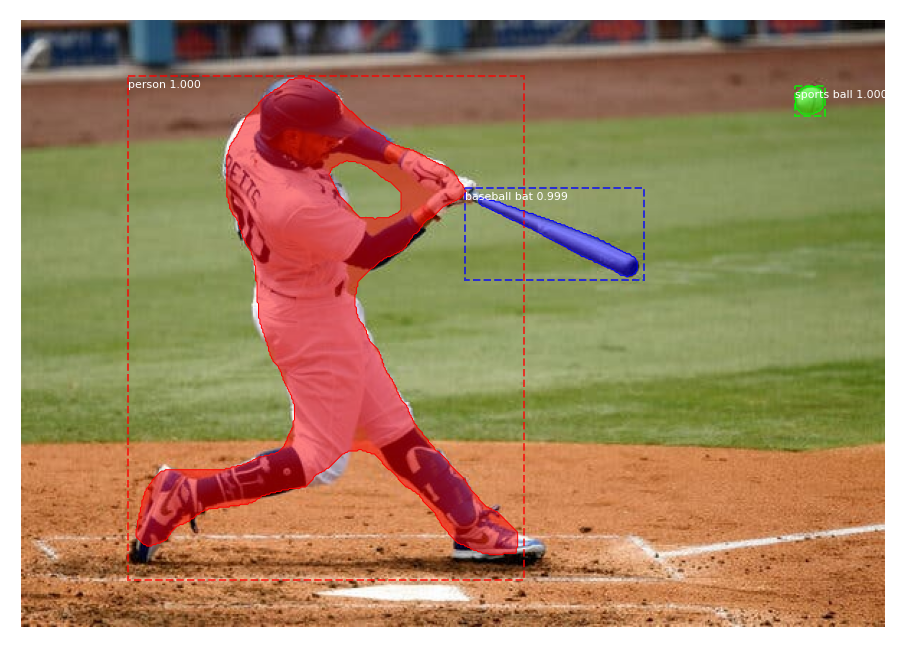

In [20]:
#detection

# Load a random image from the images folder
file_names = os.listdir(IMAGE_DIR)
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# Video

In [14]:
#generate color mask and bounding boxes for different class

def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors

colors = random_colors(len(class_names))

#one static color for each class
class_dict = {
    name: color for name, color in zip(class_names, colors)
}

In [15]:
def display_instance(image, boxes, ids, names, scores):
    classes = boxes.shape[0]
    
    if not classes:
        print('No object detected')
    else:
        assert boxes.shape[0] == ids.shape[0]
        
        
    for i in range(classes):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        colors = class_dict[label]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        #mask = masks[:, :, i]

        #image = apply_mask(image, mask, colors)
        image = cv.rectangle(image, (x1, y1), (x2, y2), colors, 2)
        image = cv.putText(
            image, caption, (x1, y1), cv.FONT_HERSHEY_COMPLEX, 0.7, colors, 2
        )
        print(caption)
    return image

In [18]:
#type the file name of the video, or type 0 to use webcam
Video = cv.VideoCapture(0)
#Check if we can open the video
if(Video.isOpened()==False):
    Video = cv.VideoCapture
if(Video.isOpened()== False):
    raise IOError("Error: Can't open video file")

#if we don't need a normal spped video, comment the following 2 lines
size = (
    int(Video.get(cv.CAP_PROP_FRAME_WIDTH)),
    int(Video.get(cv.CAP_PROP_FRAME_HEIGHT))
)

#if we don't need a normal spped video, comment the following 2 lines
codec = cv.VideoWriter_fourcc(*'DIVX')
output = cv.VideoWriter('example.avi', codec, 60.0, size)

    
while(Video.isOpened()):
    ret, frame = Video.read()
    results = model.detect([frame], verbose=0)
    if ret == True:
        r = results[0]
        frame = display_instance(frame, r['rois'], r['class_ids'], 
                            class_names, r['scores'])
        
        #if we don't need a normal spped video, comment the following  line
        output.write(frame)
        
        cv.imshow('Frame',frame)
    
        if cv.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break   


Video.release()

#if we don't need a normal spped video, comment the following line
output.release()

cv.destroyAllWindows()

person 1.00
bottle 0.89
person 0.89
person 1.00
bottle 0.88
person 1.00
person 1.00
chair 0.79
person 0.93
chair 0.85
person 1.00
person 1.00
person 1.00
chair 0.91
mouse 0.79
person 0.77
person 1.00
handbag 0.82
person 0.71
person 0.99
chair 0.91
cell phone 0.83
person 0.99
chair 0.93
person 1.00
chair 0.72
person 1.00
person 0.91
person 1.00
bottle 0.99
person 0.94
chair 0.75
person 1.00
bottle 0.81
person 1.00
chair 0.92
person 0.85
person 1.00
person 1.00
bottle 1.00
chair 0.87
person 0.79
person 1.00
chair 0.91
person 1.00
couch 0.80
person 1.00
chair 0.93
person 1.00
person 0.95
chair 0.84
person 0.98
chair 0.78
remote 0.77
person 1.00
bottle 0.92
chair 0.86
chair 0.85
person 1.00
bottle 0.96
chair 0.84
chair 0.70
person 1.00
bottle 0.96
chair 0.91
chair 0.85
person 1.00
bottle 0.97
chair 0.93
person 1.00
person 0.96
person 1.00
person 0.89
person 1.00
person 0.92
person 1.00
sports ball 0.93
person 1.00
person 1.00
person 0.78
frisbee 0.77
person 1.00
person 0.85
person 1.00
bot